# Reddit Sentiment Anlysis: London low-traffic Neighborhood zones


# 1. Data "Aquisition"
---

Reddit r/London scraping script
- accesses json endpoint 
- looks for given keywords 
- gets given number of posts + 5 comments each

In [5]:
import requests
import pandas as pd
import time
from datetime import datetime
from urllib.parse import quote
import json

BASE_URL = "https://www.reddit.com"
HEADERS = {'User-Agent': 'LTN_Sentiment_Analysis (University of Amsterdam)'}

keywords = [
    "low traffic neighbourhood",
    "low-traffic neighbourhood",
    "LTN",
    "low-traffic zones"
]

POSTS_PER_KEYWORD = 40  # Single control point for limit

results = []
seen_posts = set()


def search_keyword(keyword, retries=3, backoff=2):
    url = f"{BASE_URL}/search.json?q={quote(keyword)}&sort=relevance&limit=100&t=all"
    for attempt in range(1, retries + 1):
        try:
            resp = requests.get(url, headers=HEADERS, timeout=10)
            if resp.status_code == 429:
                wait = backoff * attempt
                print(f"Rate limited (429). Sleeping {wait}s then retrying...")
                time.sleep(wait)
                continue
            resp.raise_for_status()
            try:
                data = resp.json()
            except json.JSONDecodeError:
                print("Failed to decode JSON from search endpoint; response snippet:")
                print(resp.text[:300])
                return []
            return data.get('data', {}).get('children', [])
        except requests.exceptions.RequestException as e:
            print(f"Request error (attempt {attempt}/{retries}): {e}")
            time.sleep(backoff * attempt)
    return []


def get_comments(post_id, retries=2):
    url = f"{BASE_URL}/comments/{post_id}.json"
    try:
        resp = requests.get(url, headers=HEADERS, timeout=10)
        resp.raise_for_status()
        try:
            data = resp.json()
        except json.JSONDecodeError:
            print(f"Failed to decode JSON when fetching comments for {post_id}")
            return []
        return data[1].get('data', {}).get('children', []) if len(data) >= 2 else []
    except requests.exceptions.RequestException as e:
        print(f"Request error fetching comments for {post_id}: {e}")
        return []


def process_comments(comment_data, post_id, post_title, max_comments=5):
    comments = []

    for item in comment_data:
        if len(comments) >= max_comments:
            break

        if item.get('kind') == 't1':
            comment = item['data']
            body = comment.get('body', '')

            if body and body not in ('[removed]', '[deleted]'):
                comments.append({
                    'type': 'comment',
                    'title': '',
                    'created_utc': datetime.fromtimestamp(
                        comment.get('created_utc', 0)
                    ).strftime('%Y-%m-%d %H:%M:%S'),
                    'body': body,
                    'num_comments': '',
                    'url': f"https://www.reddit.com{comment.get('permalink', '')}",
                    'keyword_matched': '',
                    'parent_post_title': post_title,
                })

            if len(comments) < max_comments:
                replies = comment.get('replies', {})
                if isinstance(replies, dict):
                    children = replies.get('data', {}).get('children', [])
                    comments.extend(
                        process_comments(
                            children,
                            post_id,
                            post_title,
                            max_comments - len(comments),
                        )
                    )

    return comments


## Nice Progress Bar by chat gpt :)

In [6]:
# Reusable progress bar function
def print_progress_bar(current, total, bar_length=40, label="Progress"):
    percent = current / total
    filled = int(bar_length * percent)
    bar = '█' * filled + '░' * (bar_length - filled)
    print(f"\r  {label}: [{bar}] {current}/{total}", end='', flush=True)

## Main Function


In [7]:
POSTS_PER_KEYWORD = 100  # Single control point for limit

def main():
    print(f"Starting json scraping script --> Collecting {POSTS_PER_KEYWORD} posts for every keyword with 5 comments each\n")

    for idx, keyword in enumerate(keywords, 1):
        print(f"Keyword [{idx}/{len(keywords)}]: '{keyword}'")
        posts = search_keyword(keyword)
        keyword_count = 0
        
        for post_item in posts:
            if keyword_count >= POSTS_PER_KEYWORD:
                break
            if post_item.get('kind') != 't3':
                continue
            post = post_item['data']
            post_id = post.get('id', '')
            if post_id in seen_posts or not post_id:
                continue
            seen_posts.add(post_id)
            keyword_count += 1
            
            results.append({
                'type': 'post',
                'title': post.get('title', ''),
                'created_utc': datetime.fromtimestamp(post.get('created_utc', 0)).strftime('%Y-%m-%d %H:%M:%S'),
                'body': post.get('selftext', ''),
                'num_comments': post.get('num_comments', 0),
                'url': f"{URL}{post.get('permalink', '')}",
                'keyword_matched': keyword,
                'parent_post_title': '',
            })
            
            if post.get('num_comments', 0) > 0:
                time.sleep(1)
                comments = process_comments(get_comments(post_id), post_id, post.get('title', ''))
                results.extend(comments)
            
            print_progress_bar(keyword_count, POSTS_PER_KEYWORD, label="Progress")
            time.sleep(1)
        
        print("\n")
    
    df = pd.DataFrame(results)
    df.to_csv("ltn_london_reddit_scraped2.csv", index=False, encoding='utf-8')
    print(f"✓ Saved {len(df[df['type'] == 'post'])} posts and {len(df[df['type'] == 'comment'])} comments")


if __name__ == "__main__":
    main()

Starting json scraping script --> Collecting 100 posts for every keyword with 5 comments each

Keyword [1/4]: 'low traffic neighbourhood'
  Progress: [████████████████████████████████████████] 100/100

Keyword [2/4]: 'low-traffic neighbourhood'
  Progress: [██░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░] 6/100

Keyword [3/4]: 'LTN'
  Progress: [██░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░] 7/100Request error fetching comments for 1igfx19: 429 Client Error: Too Many Requests for url: https://www.reddit.com/comments/1igfx19.json
  Progress: [███░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░] 8/100Request error fetching comments for 1jw265o: 429 Client Error: Too Many Requests for url: https://www.reddit.com/comments/1jw265o.json
  Progress: [███░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░] 9/100Request error fetching comments for 1pvonn6: 429 Client Error: Too Many Requests for url: https://www.reddit.com/comments/1pvonn6.json
  Progress: [████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░] 10/100Request error fetching com

# 2. Cleaning Data
---

Use AI  to check if each post is geniunely about LTN 

- script only saves context relevant post and their comments 
- small local LLM model (llama3.2:3b --> best for my laptop)

In [8]:
import pandas as pd
import ollama
import time

INPUT_FILE = 'ltn_london_reddit_scraped2.csv'
OUTPUT_FILE = 'filtered_ltn_reddit2.csv'
MODEL_NAME = 'llama3.2:3b'  # Optimized for 8GB RAM with M2 chip

# Load data
df = pd.read_csv(INPUT_FILE)
print(f"Loaded {len(df)} entries. Filtering with AI...\n")


def filter_ltn():
    filtered = []
    # initialize Answer column (default 'No')
    df['Answer'] = 'No'

    for idx, row in df.iterrows():
        title = str(row.get('title', '')) if pd.notna(row.get('title')) else ""
        body = str(row.get('body', '')) if pd.notna(row.get('body')) else ""

        prompt = f"""Is this post about Low Traffic Neighbourhoods (LTN) in London UK?

Title: {title}
Text: {body[:500]}

Answer ONLY 'yes' or 'no'."""

        response = ollama.generate(model=MODEL_NAME, prompt=prompt, options={'temperature': 0.2, 'num_predict': 5})

        ans_text = response.get('response', '').strip().lower()
        if 'yes' in ans_text:
            df.at[idx, 'Answer'] = 'Yes'
            filtered.append(row)
        else:
            df.at[idx, 'Answer'] = 'No'

        print_progress_bar(idx + 1, len(df), label="Filtering")
        time.sleep(0.3)

    return pd.DataFrame(filtered)


filtered_df = filter_ltn()
# Save filtered entries to a new CSV
filtered_df.to_csv(OUTPUT_FILE, index=False)
# Save annotated original CSV with Answer column
df.to_csv(INPUT_FILE, index=False)

print(f"\n\n✓ Saved {len(filtered_df)} entries to {OUTPUT_FILE}")
print(f"✓ Annotated original file and saved to {INPUT_FILE}")

Loaded 663 entries. Filtering with AI...

  Filtering: [████████████████████████████████████████] 663/663

✓ Saved 340 entries to filtered_ltn_reddit2.csv
✓ Annotated original file and saved to ltn_london_reddit_scraped2.csv


# Human-LLM Agreement
---
Checking 50 entries to see if outputs are reliable

In [2]:
SAMPLE_TOTAL = 50
INPUT_SCRAPED = "ltn_london_reddit_scraped2.csv"
OUTPUT_FILE = "human_ai_validation.csv"

df_src = pd.read_csv(INPUT_SCRAPED)

df_src['Answer'] = df_src['Answer'].astype(str).str.strip().str.capitalize()
labels = sorted(df_src['Answer'].dropna().unique())
per_label = (SAMPLE_TOTAL + len(labels) - 1) // len(labels)

samples = [
    df_src[df_src['Answer'] == lab].sample(min(per_label, len(df_src[df_src['Answer'] == lab])), random_state=42)
    for lab in labels
]

sampled = pd.concat(samples).reset_index(drop=True)

if len(sampled) < SAMPLE_TOTAL:
    extra = df_src.drop(sampled.index).sample(SAMPLE_TOTAL - len(sampled), random_state=42)
    sampled = pd.concat([sampled, extra]).reset_index(drop=True)

# Add human annotation columns and text column
sampled['human_label'] = ""
sampled['notes'] = ""
if 'text' not in sampled.columns:
    sampled['text'] = sampled.get('title', "").fillna("").astype(str) + " " + sampled.get('body', "").fillna("").astype(str)

cols_to_save = [c for c in ['created_utc', 'title', 'text', 'body', 'url', 'Answer'] if c in sampled.columns]
cols_to_save += ['human_label', 'notes']

sampled.to_csv(OUTPUT_FILE, columns=cols_to_save, index=False)
print(f"✓ Exported {len(sampled)} entries to {OUTPUT_FILE}")
print(sampled['Answer'].value_counts())

✓ Exported 50 entries to human_ai_validation.csv
Answer
No     25
Yes    25
Name: count, dtype: int64


## Accuracy

In [5]:
import pandas as pd

# Simple Yes/No accuracy: compare AI 'Answer' and human 'human_label'
df = pd.read_csv("human_ai_validation.csv")

# normalize to yes/no lowercase
df['Answer'] = df['Answer'].astype(str).str.strip().str.lower()
df['human_label'] = df['human_label'].astype(str).str.strip().str.lower()

# Keep only explicit yes/no human annotations
annot = df[df['human_label'].isin(['yes','no'])].copy()
print(f"Annotated rows (yes/no): {len(annot)}")
if len(annot) == 0:
    print("No human 'yes'/'no' annotations found. Fill 'human_label' with 'Yes' or 'No'.")
else:
    matches = (annot['Answer'] == annot['human_label']).astype(int)
    acc = matches.mean()
    print(f"Accuracy (AI Answer == human_label): {acc:.2%}\n")
    print("Counts (human_label):")
    print(annot['human_label'].value_counts())
    print("\nConfusion (human_label vs AI Answer):")
    print(pd.crosstab(annot['human_label'], annot['Answer']))

Annotated rows (yes/no): 50
Accuracy (AI Answer == human_label): 92.00%

Counts (human_label):
human_label
yes    29
no     21
Name: count, dtype: int64

Confusion (human_label vs AI Answer):
Answer       no  yes
human_label         
no           21    0
yes           4   25


# TF-IDF per year
---

In [6]:
import pandas as pd
import re
from collections import Counter
from math import log
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# load the data
df = pd.read_csv("filtered_ltn_reddit2.csv")

# Parse datetime (your format is already standard)
df["created_utc"] = pd.to_datetime(df["created_utc"])

# Combine title + body
df["text"] = df["title"].astype(str) + " " + df["body"].astype(str)

# group by month
df["month"] = df["created_utc"].dt.to_period("M").astype(str) + "-01"

grouped = (
    df.groupby("month")["text"]
    .apply(" ".join)
    .reset_index()
)

print(f"Documents (months): {len(grouped)}")

#text processing
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-z\s]", " ", text)
    return text

def tokenization(text):
    return word_tokenize(text)

def remove_stopwords(tokens):
    return [t for t in tokens if t not in stop_words and len(t) > 2]

def lemmatize(tokens):
    return [lemmatizer.lemmatize(t) for t in tokens]

grouped["tokens"] = (
    grouped["text"]
    .apply(clean_text)
    .apply(tokenization)
    .apply(remove_stopwords)
    .apply(lemmatize)
)

# TF-IDF (manual,per month)
def compute_tf_idf_manual(docs):
    """
    docs: list of token lists (one per month)
    """
    N = len(docs)
    df_counts = Counter()

    for doc in docs:
        for term in set(doc):
            df_counts[term] += 1

    tfidf_docs = []

    for doc in docs:
        tf = Counter(doc)
        doc_len = len(doc)
        tfidf = {}

        for term, count in tf.items():
            tf_val = count / doc_len
            idf_val = log(N / (1 + df_counts[term]))
            tfidf[term] = tf_val * idf_val

        tfidf_docs.append(tfidf)

    return tfidf_docs

grouped["tfidf"] = compute_tf_idf_manual(grouped["tokens"].tolist())

# top terms per month
def get_highest_values(tfidf_dict, n=5):
    return sorted(tfidf_dict.items(), key=lambda x: x[1], reverse=True)[:n]

grouped["tfidf_top"] = grouped["tfidf"].apply(get_highest_values)

# print year by year
grouped["year"] = grouped["month"].str[:4]

for year in grouped["year"].unique():
    gy = grouped[grouped["year"] == year]
    print(
        year,
        [terms[0][0] for terms in gy["tfidf_top"]]
    )


Documents (months): 47
2019 ['grid']
2020 ['general', 'islington', 'trial', 'mainly', 'quintiles', 'farage']
2021 ['dual', 'encourage', 'dft', 'gent']
2022 ['care', 'anonymity', 'warrior', 'hanover', 'pollution']
2023 ['making', 'protest', 'famously', 'bcc', 'tutorial', 'evidence', 'sunak', 'fixing', 'appears']
2024 ['battle', 'report', 'heaton', 'amenity', 'exeter', 'sign', 'nh', 'pcn', 'forced', 'iron']
2025 ['furious', 'leith', 'affluent', 'pushing', 'train', 'highway', 'injury', 'single', 'pedestrian', 'wagon', 'restriction', 'sub']


# 3. Sentiment Analysis 
---


Basic sentiment Analysis with Vader

In [7]:
import pandas as pd
try:
    from transformers import pipeline
except Exception as e:
    raise ImportError("Please install transformers and torch: pip install transformers torch") from e

# load the data
df = pd.read_csv('filtered_ltn_reddit2.csv')
print(f"Analyzing {len(df)} entries...\n")

# Create a sentiment pipeline using the CardiffNLP model
nlp = pipeline(
    "sentiment-analysis",
    model="cardiffnlp/twitter-roberta-base-sentiment-latest",
    tokenizer="cardiffnlp/twitter-roberta-base-sentiment-latest",
    return_all_scores=True,
)

# Prepare texts (match Vader logic: title for posts, body for comments)
texts = []
for _, row in df.iterrows():
    if row.get('type') == 'post':
        text = str(row.get('title', ''))
    else:
        text = str(row.get('body', ''))
    if not text or text == 'nan':
        text = str(row.get('body', ''))
    texts.append(text)

# Run in batches for efficiency
results = nlp(texts, truncation=True, batch_size=32)

sentiment_scores = []
sentiment_labels = []
for res in results:
    # res is a list of dicts like [{'label':'NEGATIVE','score':0.9}, ...]
    if isinstance(res, dict):
        # unexpected single dict — normalize
        res_list = [res]
    else:
        res_list = res
    score_map = {d['label'].lower(): d['score'] for d in res_list}
    pos = score_map.get('positive', 0.0)
    neu = score_map.get('neutral', 0.0)
    neg = score_map.get('negative', 0.0)

    # sentiment_score: positive minus negative (approx -1..1)
    sentiment_scores.append(pos - neg)

    # label by highest probability
    if pos >= neg and pos >= neu:
        sentiment_labels.append('Positive')
    elif neg >= pos and neg >= neu:
        sentiment_labels.append('Negative')
    else:
        sentiment_labels.append('Neutral')

# Save results to dataframe
df['sentiment_score'] = sentiment_scores
df['sentiment_label'] = sentiment_labels

# print distribution
counts = df['sentiment_label'].value_counts()
total = len(df)

print(
    f"\nSentiment Distribution:\n"
    f"  Positive: {counts.get('Positive', 0)/total*100:.1f}%\n"
    f"  Neutral:  {counts.get('Neutral', 0)/total*100:.1f}%\n"
    f"  Negative: {counts.get('Negative', 0)/total*100:.1f}%"
)


Analyzing 340 entries...


Sentiment Distribution:
  Positive: 41.2%
  Neutral:  18.2%
  Negative: 40.6%


# 4. Inter-Annotator Agreement
---
Checking whether these outputs are reliable by looking at 60 entries.

In [8]:
# this makes a file in which I can fill in the human_label (so whether I find the entry positive, negative or neutral)
SAMPLE_SIZE = 20  # per class

sampled = pd.concat([
    df[df['sentiment_label'] == 'Positive'].sample(SAMPLE_SIZE, random_state=42),
    df[df['sentiment_label'] == 'Neutral'].sample(SAMPLE_SIZE, random_state=42),
    df[df['sentiment_label'] == 'Negative'].sample(SAMPLE_SIZE, random_state=42),
])

# Columns for human annotation
sampled['human_label'] = ""
sampled['notes'] = ""

# Combine text for easier reading
sampled['text'] = (
    sampled['title'].fillna("").astype(str) + " " +
    sampled['body'].fillna("").astype(str)
)

# Export for manual checking
sampled[[
    'created_utc',
    'text',
    'sentiment_score',
    'sentiment_label',
    'human_label'
]].to_csv('sentiment_human_validation.csv', index=False)

print("\n✓ Exported sentiment_human_validation.csv for manual annotation")



✓ Exported sentiment_human_validation.csv for manual annotation


# Check the Human–VADER agreement

In [13]:
import pandas as pd

# Read CSV with semicolon separator
val = pd.read_csv("sentiment_human_validation.csv", sep=',', on_bad_lines='skip')

# Strip any whitespace from column names
val.columns = val.columns.str.strip()

# Check the column names
print(val.columns.tolist())

# Now calculate agreement
accuracy = (val["sentiment_label"] == val["human_label"]).mean()
print(f"Human–VADER agreement: {accuracy:.2%}")

# Confusion matrix
confusion = pd.crosstab(
    val["human_label"],
    val["sentiment_label"],
    normalize="index"
)
print(confusion)

['created_utc', 'text', 'sentiment_score', 'sentiment_label', 'human_label']
Human–VADER agreement: 65.00%
sentiment_label  Negative   Neutral  Positive
human_label                                  
Negative         0.666667  0.166667  0.166667
Neutral          0.291667  0.625000  0.083333
Positive         0.208333  0.125000  0.666667


Results:
#
Here we assume the human is the correct answer.
- Negative was correct 66% of the time
- Neutral was correct 62% of the time
- Positive was correct 66% of the time
#
Interpretation
- Vader is biased towards detecting negative sentiment, it over-predicts Negative for neutral posts.
- Neutral posts are hardest for Vader.
- Vader performs reasonably well for strongly polarized posts, but struggles to identify neutral or mixed sentiment.




# Sentiment Analysis with pre-trained transformer based model 
---
- https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest 



In [4]:
import pandas as pd
try:
    from transformers import pipeline
except Exception as e:
    raise ImportError("Please install transformers and torch: pip install transformers torch") from e

# load the filtered data
df = pd.read_csv("filtered_ltn_reddit2.csv")
print(f"Analyzing {len(df)} entries...\n")

# Create a sentiment pipeline using the CardiffNLP model
nlp = pipeline(
    "sentiment-analysis",
    model="cardiffnlp/twitter-roberta-base-sentiment-latest",
    tokenizer="cardiffnlp/twitter-roberta-base-sentiment-latest",
    top_k=None,  # return scores for all labels
)

# prepare texts (title for posts, body for comments)
texts = []
for _, row in df.iterrows():
    if row.get('type') == 'post':
        text = str(row.get('title', ''))
    else:
        text = str(row.get('body', ''))
    if not text or text == 'nan':
        text = str(row.get('body', ''))
    texts.append(text)

# Run in batches for efficiency; specify max_length to avoid truncation warning
results = nlp(texts, truncation=True, max_length=128, batch_size=32, top_k=None)

sentiment_scores = []
sentiment_labels = []
for res in results:
    # res is a list of dicts like [{'label':'NEGATIVE','score':0.9}, ...]
    if isinstance(res, dict):
        # unexpected single dict — normalize
        res_list = [res]
    else:
        res_list = res
    score_map = {d['label'].lower(): d['score'] for d in res_list}
    pos = score_map.get('positive', 0.0)
    neu = score_map.get('neutral', 0.0)
    neg = score_map.get('negative', 0.0)

    # sentiment_score: positive minus negative (approx -1..1)
    sentiment_scores.append(pos - neg)

    # label by highest probability
    if pos >= neg and pos >= neu:
        sentiment_labels.append('Positive')
    elif neg >= pos and neg >= neu:
        sentiment_labels.append('Negative')
    else:
        sentiment_labels.append('Neutral')

# Save results to dataframe
df['sentiment_score_cardiff'] = sentiment_scores
df['sentiment_label_cardiff'] = sentiment_labels

# Save annotated filtered CSV so agreement cells can use it
df.to_csv("filtered_ltn_reddit2.csv", index=False)
print(f'✓ Saved annotated filtered file with Cardiff labels to filtered_ltn_reddit2.csv')

# print distribution (like the Vader cell did)
counts = df['sentiment_label_cardiff'].value_counts()
total = len(df)

print(
    f"\nSentiment Distribution (CardiffNLP):\n" +
    f"  Positive: {counts.get('Positive', 0)/total*100:.1f}%\n" +
    f"  Neutral:  {counts.get('Neutral', 0)/total*100:.1f}%\n" +
    f"  Negative: {counts.get('Negative', 0)/total*100:.1f}%"
)


Analyzing 340 entries...



Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use mps:0


✓ Saved annotated filtered file with Cardiff labels to filtered_ltn_reddit2.csv

Sentiment Distribution (CardiffNLP):
  Positive: 12.4%
  Neutral:  43.5%
  Negative: 44.1%


## Human-Transformer Agreement

In [5]:
# Export a balanced sample (20 per Cardiff label) for human annotation
import pandas as pd
SAMPLE_PER_LABEL = 20
INPUT_FILE = 'filtered_ltn_reddit2.csv'
OUTPUT_FILE = 'sentiment_transformer_human_validation.csv'

df = pd.read_csv(INPUT_FILE)
# Ensure the transformer label column exists
if 'sentiment_label_cardiff' not in df.columns:
    raise KeyError('sentiment_label_cardiff not found in filtered_ltn_reddit2.csv — run the Cardiff cell first')

labels = ['Positive', 'Neutral', 'Negative']
samples = []
for lab in labels:
    subset = df[df['sentiment_label_cardiff'] == lab]
    if len(subset) == 0:
        # skip if no examples for this label
        continue
    n = min(SAMPLE_PER_LABEL, len(subset))
    samples.append(subset.sample(n, random_state=42))

if len(samples) == 0:
    raise ValueError('No examples found for any label — check sentiment_label_cardiff values')

sampled = pd.concat(samples).reset_index(drop=True)
target_total = SAMPLE_PER_LABEL * len(labels)
if len(sampled) < target_total:
    # add extra random samples from remaining pool to reach target size
    remaining = df.drop(sampled.index, errors='ignore')
    need = target_total - len(sampled)
    if len(remaining) > 0 and need > 0:
        extra = remaining.sample(min(need, len(remaining)), random_state=42)
        sampled = pd.concat([sampled, extra]).reset_index(drop=True)

# Add human annotation placeholders
sampled['human_label'] = ''
sampled['notes'] = ''
# create a combined text field for annotation convenience
sampled['text'] = sampled.get('title', '').fillna('').astype(str) + ' ' + sampled.get('body', '').fillna('').astype(str)

cols = [c for c in ['created_utc', 'title', 'text', 'sentiment_score_cardiff', 'sentiment_label_cardiff', 'url', 'keyword_matched'] if c in sampled.columns]
cols += ['human_label', 'notes']
sampled.to_csv(OUTPUT_FILE, columns=cols, index=False)
print(f'✓ Exported {len(sampled)} examples to {OUTPUT_FILE} (up to {SAMPLE_PER_LABEL} per label)')

✓ Exported 60 examples to sentiment_transformer_human_validation.csv (up to 20 per label)


### Accuracy

---
# New version: TF-IDF and Logistic regression

In [ ]:
from sklearn.model_selection import train_test_split

df_labeled = df.dropna(subset=["human_label"]).reset_index(drop=True)

print("Number of labeled examples:", len(df_labeled))
print(df_labeled["human_label"].value_counts())

X = df_labeled["text"].astype(str)
y = df_labeled["human_label"].astype(str)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")

This tells us the amount of entries we will use for the training and testing.

# Train the data

In [85]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

clf = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=(1, 2),
        min_df=2,
        max_df=0.9,
        stop_words="english"
    )),
    ("logreg", LogisticRegression(
        max_iter=2000,
        class_weight="balanced",
        n_jobs=-1
    ))
])

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("Classification report:")
print(classification_report(y_test, y_pred))

print("Confusion matrix (rows=true, cols=predicted):")
print(confusion_matrix(y_test, y_pred))

Classification report:
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00         2
     Neutral       0.60      0.50      0.55         6
    Positive       0.40      0.50      0.44         4

    accuracy                           0.42        12
   macro avg       0.33      0.33      0.33        12
weighted avg       0.43      0.42      0.42        12

Confusion matrix (rows=true, cols=predicted):
[[0 1 1]
 [1 3 2]
 [1 1 2]]


Interpretation:
- Overall performance is weak: accuracy ≈ 42%, macro F1 ≈ 0.33 on only 12 test samples.
- The model fails on Negative: recall and precision are 0.0; it never correctly predicts Negative.
- Neutral is best: recall 0.50, but still often confused with Positive/Negative.
- Positive is mixed: recall 0.50, with frequent misclassification.

# Prepare labeled data and split

In [87]:
import pandas as pd
from sklearn.model_selection import train_test_split

# df is already loaded and cleaned
# Make sure human_label missing values are real NaNs
df["human_label"] = df["human_label"].replace("", pd.NA).str.strip()

# Keep only rows that actually have a human label
df_labeled = df.dropna(subset=["human_label"]).reset_index(drop=True)

print("Number of labeled examples:", len(df_labeled))
print(df_labeled["human_label"].value_counts())

X = df_labeled["text"].astype(str)
y = df_labeled["human_label"].astype(str)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,    # ~80% train, 20% test
    random_state=42,
    stratify=y        # preserve label proportions
)

print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")

Number of labeled examples: 59
human_label
Neutral     28
Positive    18
Negative    13
Name: count, dtype: int64
Train size: 47, Test size: 12


# TF‑IDF + Logistic Regression

In [88]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

# Build pipeline
clf = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=(1, 2),   # unigrams + bigrams
        min_df=1,             # small dataset → allow rare terms
        max_df=0.9,
        stop_words="english"
    )),
    ("logreg", LogisticRegression(
        max_iter=2000,
        class_weight="balanced",  # helpful with class imbalance
        n_jobs=-1
    ))
])

# Train
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)

print("Classification report:")
print(classification_report(y_test, y_pred))

print("Confusion matrix (rows=true, cols=predicted):")
print(confusion_matrix(y_test, y_pred, labels=sorted(y.unique())))
print("Label order in confusion matrix:", sorted(y.unique()))

Classification report:
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00         2
     Neutral       0.67      0.67      0.67         6
    Positive       0.33      0.25      0.29         4

    accuracy                           0.42        12
   macro avg       0.33      0.31      0.32        12
weighted avg       0.44      0.42      0.43        12

Confusion matrix (rows=true, cols=predicted):
[[0 1 1]
 [1 4 1]
 [2 1 1]]
Label order in confusion matrix: ['Negative', 'Neutral', 'Positive']


Interpretation:
- Overall performance is still weak: accuracy ≈ 42%, macro F1 ≈ 0.32 on 12 samples.
- The model again fails on Negative: precision/recall = 0.0 (no true Negatives correctly predicted).
- Neutral is okay: precision and recall both 0.67 (4/6 Neutrals correct).
- Positive is poor: recall 0.25 (only 1/4 Positives correct), often misclassified as Negative or Neutral.

# Overall label distribution

In [91]:
print(reddit["model_label"].value_counts())
print("\nRelative frequencies (%):")
print(reddit["model_label"].value_counts(normalize=True) * 100)

model_label
Neutral     121
Negative     74
Positive     52
Name: count, dtype: int64

Relative frequencies (%):
model_label
Neutral     48.987854
Negative    29.959514
Positive    21.052632
Name: proportion, dtype: float64


Save it into a file so we can later plot it

In [93]:
import joblib

joblib.dump(clf, "sentiment_tfidf_logreg.pkl")
print("Model saved as sentiment_tfidf_logreg.pkl")

Model saved as sentiment_tfidf_logreg.pkl


# Limitations:
- Very small test set (12 examples)
# 
This makes accuracy and F1 highly unstable; a few misclassifications can change the numbers a lot, so they may not generalise to the wider Reddit data.
- Few total human‑labelled examples (~60)
#
With so little training data, the model can’t reliably learn the relationship between text and sentiment, so its behaviour is likely noisy and overfitted to this small sample.

# 5. Visualization over the years
---

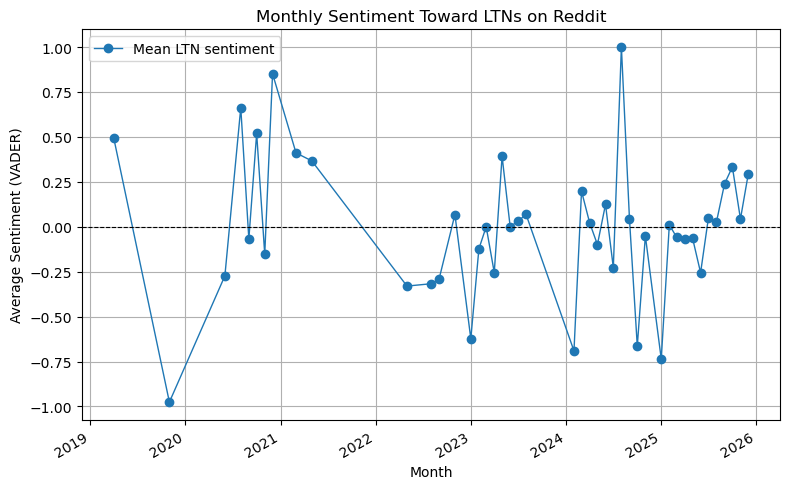

In [ ]:
# visualization of VADER
import pandas as pd
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# load the data
df = pd.read_csv("ltn_overall_filtered_reddit.csv")

# Parse datetime
df["created_utc"] = pd.to_datetime(df["created_utc"])

# Combine title + body (posts + comments safely)
df["text"] = (
    df["title"].fillna("").astype(str) + " " +
    df["body"].fillna("").astype(str)
)

# sentiment analysis
analyzer = SentimentIntensityAnalyzer()

df["sentiment"] = df["text"].apply(
    lambda x: analyzer.polarity_scores(x)["compound"]
)

# group by month
df["month"] = df["created_utc"].dt.to_period("M").astype(str) + "-01"
df["month"] = pd.to_datetime(df["month"])

monthly_sentiment = (
    df.groupby("month")["sentiment"]
    .mean()
)

# plot
fig, ax = plt.subplots(figsize=(8, 5))

monthly_sentiment.plot(
    ax=ax,
    marker="o",
    lw=1,
    label="Mean LTN sentiment"
)

ax.set_xlabel("Month")
ax.set_ylabel("Average Sentiment (VADER)")
ax.set_title("Monthly Sentiment Toward LTNs on Reddit")

ax.axhline(0, color="black", linestyle="--", linewidth=0.8)

ax.grid(True)
fig.tight_layout()
plt.legend()
plt.show()


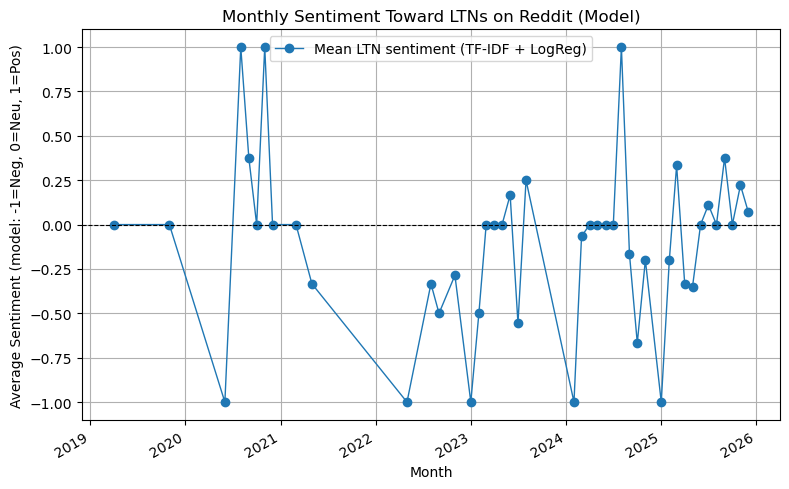

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import joblib

# load the data
df = pd.read_csv("ltn_overall_filtered_reddit.csv")

# Parse datetime
df["created_utc"] = pd.to_datetime(df["created_utc"])

# Combine title + body
df["text"] = (
    df["title"].fillna("").astype(str) + " " +
    df["body"].fillna("").astype(str)
)

# load the model and predict
clf = joblib.load("sentiment_tfidf_logreg.pkl")

df["model_label"] = clf.predict(df["text"].astype(str))

# Map labels to numeric sentiment: Positive = 1, Neutral = 0, Negative = -1
label_to_score = {"Positive": 1, "Neutral": 0, "Negative": -1}
df["sentiment_score_model"] = df["model_label"].map(label_to_score)

# group by month
df["month"] = df["created_utc"].dt.to_period("M").astype(str) + "-01"
df["month"] = pd.to_datetime(df["month"])

monthly_sentiment_model = (
    df.groupby("month")["sentiment_score_model"]
      .mean()
)

# plot
fig, ax = plt.subplots(figsize=(8, 5))

monthly_sentiment_model.plot(
    ax=ax,
    marker="o",
    lw=1,
    label="Mean LTN sentiment (TF-IDF + LogReg)"
)

ax.set_xlabel("Month")
ax.set_ylabel("Average Sentiment (model: -1=Neg, 0=Neu, 1=Pos)")
ax.set_title("Monthly Sentiment Toward LTNs on Reddit (Model)")

ax.axhline(0, color="black", linestyle="--", linewidth=0.8)
ax.grid(True)
fig.tight_layout()
plt.legend()
plt.show()

This shows that reddit users are overall pretty negative about LTN's, but seem to be more postive in this past year.